In [1]:
from matplotlib import pyplot as plt
from zipfile import ZipFile
import pandas as pd
import numpy as np
import requests
import json

In [3]:
def DkanLecture(campo=None, busquedas=None):
    url = """https://postdata.gov.co/api/action/datastore/search.json?resource_id=1895fbee-42f5-41b5-bba7-a2d03cb0f723"""
        
    if busquedas == None:
        pass
    else:
        url += f"&limit={busquedas}"
    
    if campo == None:
        pass
    else:
        url += f"&fields[]={campo}"

    js = requests.get(url)
    print("Hola")
    print(js)
    js = json.loads(js.content)
    
    df = pd.json_normalize(js["result"]["records"])
    
    return df

In [4]:
set(DkanLecture(campo = "programa", busquedas = 1000)["programa"])

Hola
<Response [200]>


{'180 GRADOS',
 'ANIMADOS ABN',
 'AVIVAMIENTO ABN',
 'BAYLESS CONLEY',
 'CAFÉ CON DIOS',
 'CINE ABN ',
 'CLUB 700 HOY',
 'CONCIERTOS ABN',
 'CORNERSTONE EN ESPAÑOL',
 'DESDE EL PÚLPITO',
 'DOMINGO FAMILIAR ',
 'DOMINGO FAMILIAR (REPETICIÓN)',
 'EL AMOR QUE VALE',
 'EL CAMPEÓN QUE HAY EN TI',
 'EL PUEDE HACERLO DE NUEVO',
 'EN CONTACTO',
 'ES SOBRENATURAL',
 'HUELLAS DEL AMADO',
 'JOYCE MEYER',
 'JUSTO A TIEMPO',
 'LA VOZ DE VICTORIA',
 'LOS PASOS DEL MAESTRO',
 'MENSAJE DE ESPERANZA',
 'MUNDO CRISTIANO',
 'MUSICA ABN',
 'NOTICIERO DEL SENADO',
 'PELICULA ABN ',
 'PLAN B',
 'PROGRAMA DEFENSOR DEL TELEVIDENTE',
 'RANDY MORRISON',
 'SIN MITÓMANOS',
 'SUPERLIBRO',
 'TIEMPOS DE ALABAR',
 'VIDA DURA',
 'VIERNES DE MILAGROS',
 'VIERNES DE MILAGROS (REPETICIÓN)',
 'VIVE +',
 'VIVE MAS',
 'VIVE MAS '}

In [2]:
test_file_name = "Parrilla_programacion_8.zip"

with ZipFile(test_file_name, 'r') as zip:
    zip.printdir()
    zip.extractall()

File Name                                             Modified             Size
Parrilla_programacion_8.csv                    2022-07-09 15:53:06    230556275


In [7]:
df = pd.read_csv("Parrilla_programacion_8.csv", sep=";", engine = "python")

,EMPRESA,ID_EMPRESA,TIPO_OPERADOR,ANNO,TRIMESTRE,FECHA,HORA_INICIO,HORA_FIN,DURACION,PROGRAMA,CLASIFICACION,GENERO,TIPO,CLOSED_CAPTION,LENGUA_SENAS,SUBTITULADO,LENGUAS_NATIVAS
0,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,00:00:33,00:28:33,00:28:00,HUELLAS DEL AMADO,FAMILIAR,NO FICCIÓN,EDUCATIVO,NINGUNO,NO,NO,NO
1,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,00:30:15,00:59:10,00:28:55,PLAN B,FAMILIAR,NO FICCIÓN,EDUCATIVO,NINGUNO,NO,NO,NO
2,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,01:00:14,02:28:14,01:28:00,DESDE EL PÚLPITO,FAMILIAR,NO FICCIÓN,PREDICACIÓN,NINGUNO,NO,NO,NO
3,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,02:30:15,03:29:15,00:59:00,MENSAJE DE ESPERANZA,FAMILIAR,NO FICCIÓN,PREDICACIÓN,NINGUNO,NO,NO,NO
4,ASOCIACIÓN COMUNIDAD DE RESTAURACIÓN,800214261,TV Sin Animo de Lucro - Local Abierta,2020,2,2020-04-01,03:30:14,03:58:14,00:28:00,EL PUEDE HACERLO DE NUEVO,FAMILIAR,NO FICCIÓN,PREDICACIÓN,NINGUNO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141286,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,20:30:00,21:00:00,00:30:00,Charlas con Aguayo,FAMILIAR,INFORMATIVO,OPINION REPORTAJES,NINGUNO,NO,NO,NO
1141287,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,21:00:00,22:00:00,01:00:00,En Contacto,FAMILIAR,INFORMATIVO,CULTURAL OPINIÓN,NINGUNO,NO,NO,NO
1141288,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,22:00:00,22:30:00,00:30:00,Entre Libros arte y cultura,FAMILIAR,INFORMATIVO,CULTURAL LITERATURA,NINGUNO,NO,NO,NO
1141289,Universidad del Valle,890399010,TV Sin Animo de Lucro - Local Abierta,2022,1,2022-03-31,22:30:00,23:00:00,00:30:00,Noti 5,FAMILIAR,INFORMATIVO,INFORMATIVO.,NINGUNO,NO,NO,NO


In [28]:
columnas = np.array(df.columns)
print(columnas)
print(f"Hay {len(columnas)} columnas")

['EMPRESA' 'ID_EMPRESA' 'TIPO_OPERADOR' 'ANNO' 'TRIMESTRE' 'FECHA'
 'HORA_INICIO' 'HORA_FIN' 'DURACION' 'PROGRAMA' 'CLASIFICACION' 'GENERO'
 'TIPO' 'CLOSED_CAPTION' 'LENGUA_SENAS' 'SUBTITULADO' 'LENGUAS_NATIVAS']
Hay 17 columnas


In [16]:
empresas = np.array(list(set(df["EMPRESA"])))
print(empresas)
print(f"Hay {len(empresas)} empresas")

['SOCIEDAD DE TELEVISION DE CALDAS RISARALDA Y QUINDIO LTDA  TELECAFÉ LTDA'
 'CORPORACION COMUNITARIA DEL MAGDALENA MEDIO '
 'CANAL REGIONAL DEL CARIBE TELECARIBE LTDA'
 'Asociación de televidentes de la estación local del NORTE- ATN'
 'CARACOL TELEVISION S.A' 'Radio Televisión Nacional de Colombia RTVC'
 'ASOCIACIÓN DE TELEVIDENTES DE LA ESTACIÓN LOCAL DEL NORTE - ATN'
 'Plural Comunicaciones SAS' 'TELEMEDELLIN' 'Arquidiócesis de Tunja'
 'Diócesis de Ipiales - Tv Ipiales Canal 24' 'CEETTV S.A.'
 'Iglesia Central Denominacion Centro Misionero Bethesda'
 'Fundación para el Desarrollo Social Promover'
 'TELEVISION REGIONAL DEL ORIENTE CANAL TRO ' 'TELECARIBE'
 ' Canal Capital '
 'ASOCIACIÓN CANAL LOCAL DE TELEVISIÓN DE MEDELLÍN "TELEMEDELLÍN"'
 'CORPORACION CANAL LOCAL UTV DEL AREA METROPOLITANA DE BUCARAMANGA'
 'SOCIEDAD DE TELEVISIÓN DEL PACÍFICO - TELEPACÍFICO LTDA' 'Canal Capital'
 'UNIVERSIDAD DEL PACÍFICO'
 'CORPORACION CANAL LOCAL DE TELEVISION CIUDADANA DEL AREA METROPOLITANA DE 

In [19]:
ids = np.array(list(set(df["ID_EMPRESA"])))
print(ids)
print(f"Hay {len(ids)} ids") 

['835000300' '811006762' '891200935' '800214261' '830012587' '830029703'
 '811006762-3' '829001133' '890937233' '901032662' '890399010' '900002583'
 '800118954' '830080615' 'Nit. 900039384-7' '900039384' '8901169650'
 '860063952' '807000294' '860025674' '890116965' '891800234' '805024229'
 '829002093' '812008353' '830005370' '804006381' '890807724' '900163045'
 '890331524']
Hay 30 ids


In [20]:
operadores = np.array(list(set(df["TIPO_OPERADOR"])))
print(operadores)
print(f"Hay {len(operadores)} tipos de operador") 

['TV Pública - Nacional Abierta' 'TV Pública - Regional Abierta'
 'TV Privada - Nacional Abierta' 'TV Privada - Local Abierta'
 'Concesión Espacios de TV Abierta Nacional'
 'TV Sin Animo de Lucro - Local Abierta']
Hay 6 tipos de operador


In [22]:
annos = np.array(list(set(df["ANNO"])))
print(annos)
print(f"Hay {len(annos)} años") 

[2019 2020 2021 2022]
Hay 4 años


In [24]:
trimestre = np.array(list(set(df["TRIMESTRE"])))
print(trimestre)
print(f"Hay {len(trimestre)} trimestres activos") 

[1 2 3 4]
Hay 4 trimestres activos


In [26]:
fecha = np.array(list(set(df["FECHA"])))
print(fecha)
print(f"Hay {len(fecha)} fechas") 

['2020-08-11' '2020-09-09' '2020-08-19' ... '2020-07-05' '2021-06-22'
 '2019-12-06']
Hay 1005 fechas


In [31]:
programas = np.array(list(set(df["PROGRAMA"])))
print(programas)
print(f"Hay {len(programas)} programas") 

["INMIGRANTES EP.06'" "PEQUENAS AVENTURERAS cc // EP.02'"
 "UNA CARTA A MOMO'" ...
 'TREINTA Y DOS REGIONALMENTE NUESTRO CCFEDERACIÓN NACIONAL DE DEPARTAMENTOS - CAP 2'
 'Micros Siempre Fashion Cap. 129 - 130 - 131 - 132 - 133 - 134'
 'Especial Laberinto']
Hay 65072 programas


In [32]:
classif = np.array(list(set(df["CLASIFICACION"])))
print(classif)
print(f"Hay {len(classif)} clasificaciones")

['FAMILIAR' 'ADOLESCENTE' 'INFANTIL' 'ADULTO' 'ND']
Hay 5 clasificaciones


In [33]:
generos = np.array(list(set(df["GENERO"])))
print(generos)
print(f"Hay {len(generos)} generos")

['FICCIÓN' 'INFANTIL' 'ND' 'NO FICCIÓN' 'INFORMATIVO']
Hay 5 generos


In [34]:
tipos = np.array(list(set(df["TIPO"])))
print(tipos)
print(f"Hay {len(tipos)} tipos de programa")

['nan' 'NOTICIERO' 'INSTITUCIONAK' 'AMINADO - INFORMATIVO' 'DEPORTIVOS'
 'FOMENTO MINTIC' 'MAGACIN' 'CONVENIO RED TAL' 'MAGAZINE DE MANUALIDADES'
 'DOCUMENTAL -DEPORTIVO' 'EVENTO DEPORTIVO' 'HISTORIA GRANDES PERSONAJES'
 'HISTORIA' 'DEPORTES RCN' 'MUJER' 'DEPORTE - INFORMATIVO'
 'MAGAZINE BALADAS' 'PREDICACIÓN' 'CONTENEDOR Y SERIE'
 'DOCUMENTAL DIVULGATIVO' 'EDUCATIVO ANIMADO' 'ICBF'
 'ENLACE CANALES REGIONALES' 'HISTORIA ANIMAL' 'FESTIVAL' 'SEMANA SANTA'
 'COPRODUCCIÓN - ALTRUISTAS DE CORAZÓN' 'NATURALEZA, TECNOLOGIA Y CIENCIA'
 'MAGAZINE POLITICO' 'CONVENIO TELECAFE' 'LICITACIÓN - NOTI5 SAS' 'AFRO'
 'CONVENIO UNIVERSIDAD DEL VALLE' 'OPINON DE CIUDAD' 'CONVENIO M' 'ETNICO'
 'REGIONAL' 'PREVENTIVO' 'MAYORES DE 12' 'INFORMAVIO' 'CIENCIA'
 'MAYORE DE 12' 'FINANCIADO FUTIC' 'CORTOMETRAJE'
 'COPRODUCCIÓN - JULIÁN AGUAYO' 'CULTURA E HISTORIA AFROCOLOMBIANA'
 'ENTREVISTA URBANAS' 'MAGAZINE RELIGIOSO' 'DOCUMENTAL ANIMADO'
 'DESFILE DE FERIA' 'LOTERIA' 'MAGAZINE INFORMATIVO' 'SERIE' 'NOTICIAS'

In [36]:
closed_c = np.array(list(set(df["CLOSED_CAPTION"])))
print(closed_c)
print(f"Hay {len(closed_c)} tipos de closed caption")

['TRANSCRIPCIÓN AUTOMÁTICA' 'ND' 'TRANSCRIPCIÓN MANUAL' 'NINGUNO']
Hay 4 tipos de closed caption


['ND' 'NO' 'SI']
Hay 3 tipos de opcion para lengua de señas, subtitulado y lenguas nativas
Frecuencias de señas:


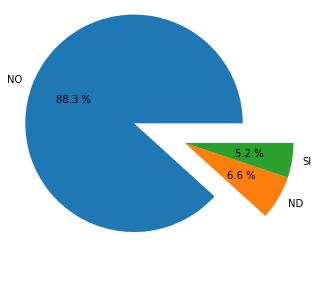

NO    1007492
SI      74775
ND      59024
Name: LENGUA_SENAS, dtype: int64


In [86]:
señas = np.array(list(set(df["LENGUA_SENAS"])))
print(señas)
print(f"Hay {len(señas)} tipos de opcion para lengua de señas, subtitulado y lenguas nativas")
freq_s = df["LENGUA_SENAS"].value_counts()
print(f"Frecuencias de señas:")
explode = (0.5, 0, 0) 
plt.figure(figsize=(5,5))
plt.pie(freq_s, explode=explode,labels=freq_nt.index, autopct="%0.1f %%" )
plt.show()
print(freq_s)

Frecuencias de subtitulado:


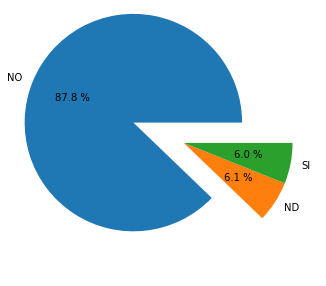

NO    1002233
SI      70023
ND      69035
Name: SUBTITULADO, dtype: int64


In [85]:
freq_sb = df["SUBTITULADO"].value_counts()
print(f"Frecuencias de subtitulado:")
explode = (0.5, 0, 0) 
plt.figure(figsize=(5,5))
plt.pie(freq_sb,explode = explode,labels=freq_nt.index, autopct="%0.1f %%")
plt.show()
print(freq_sb)

Frecuencias de  nativas:


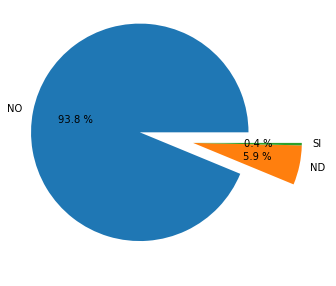

NO    1070153
ND      66987
SI       4151
Name: LENGUAS_NATIVAS, dtype: int64


In [84]:
freq_nt = df["LENGUAS_NATIVAS"].value_counts()
print(f"Frecuencias de  nativas:")
explode = (0.5, 0, 0) 
plt.figure(figsize=(5,5))
plt.pie(freq_nt,explode = explode, labels=freq_nt.index, autopct="%0.1f %%")
plt.show()
print(freq_nt)